In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, signal

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.layers import Input
from tensorflow.keras import models,Model
from tensorflow.keras import datasets
import time

%matplotlib inline

In [2]:
(X_train, _), (X_test, _) =  datasets.mnist.load_data()

x_train = np.expand_dims(X_train, 4)  #expand the last dimension
x_test = np.expand_dims(X_test,4 ) 

x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


In [3]:
x_train.shape

(60000, 28, 28, 1)

In [4]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

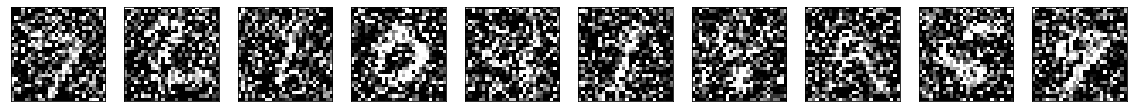

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##### Model

In [6]:
input_img = Input(shape=(28, 28, 1))

encoder1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder2 = MaxPooling2D((2, 2), padding='same')(encoder1)
encoder3 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder2)


encoded = MaxPooling2D((2, 2), padding='same',name='Compressed_Layer')(encoder3)


decoder1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
decoder2 = UpSampling2D((2, 2))(decoder1)
decoder3 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder2)
decoder4 = UpSampling2D((2, 2))(decoder3)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder4)


W0908 01:00:53.580816 14400 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
Denoise_autoencoder = Model(input_img, decoded)
Denoise_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

W0908 01:00:53.735728 14400 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


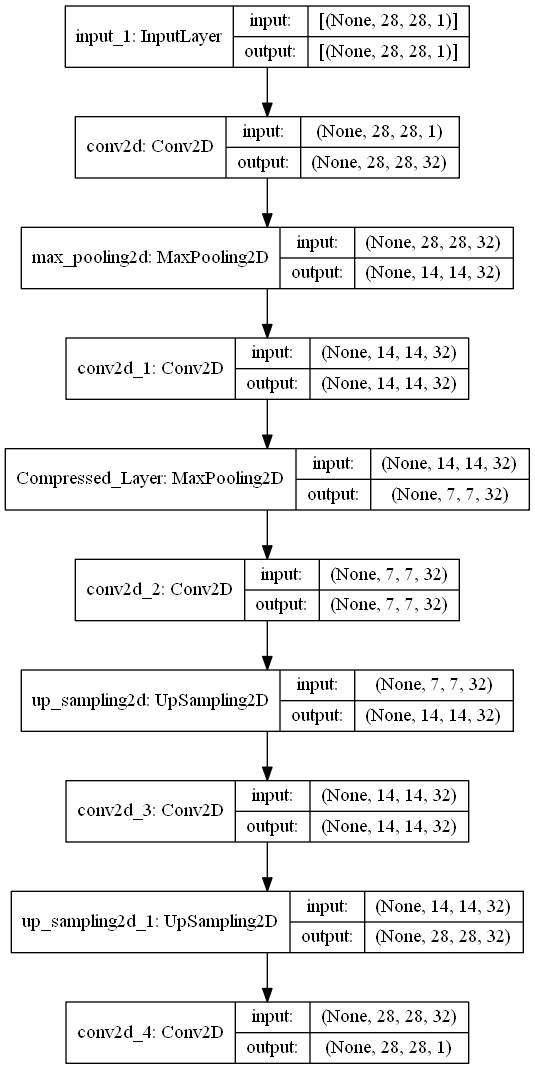

In [8]:
plot_model(Denoise_autoencoder, to_file='Denoise_ae.png', show_shapes=True)

In [9]:
epochs = 30
batch_size = 128

history = Denoise_autoencoder.fit(x_train_noisy, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 24s 397us/sample - loss: 0.1939 - val_loss: 0.1487
Epoch 2/30
60000/60000 [==============================] - 20s 335us/sample - loss: 0.1449 - val_loss: 0.1398
Epoch 3/30
60000/60000 [==============================] - 20s 336us/sample - loss: 0.1384 - val_loss: 0.1349
Epoch 4/30
60000/60000 [==============================] - 20s 335us/sample - loss: 0.1343 - val_loss: 0.1317
Epoch 5/30
60000/60000 [==============================] - 20s 335us/sample - loss: 0.1314 - val_loss: 0.1293
Epoch 6/30
60000/60000 [==============================] - 20s 334us/sample - loss: 0.1291 - val_loss: 0.1271
Epoch 7/30
60000/60000 [==============================] - 20s 334us/sample - loss: 0.1273 - val_loss: 0.1256
Epoch 8/30
60000/60000 [==============================] - 20s 334us/sample - loss: 0.1261 - val_loss: 0.1251
Epoch 9/30
60000/60000 [==============================] - 20s 335us/sample - l

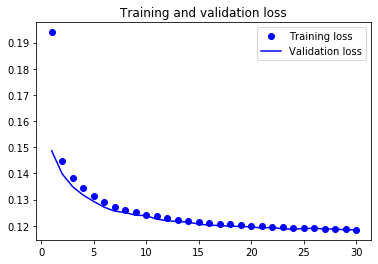

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
Denoise_encoder_latent = Model(inputs = input_img, outputs = encoded)

Denoise_encoded_imgs = Denoise_encoder_latent.predict(x_test_noisy)#compressed

Denoise_decoded_imgs = Denoise_autoencoder.predict(x_test_noisy)#reconstructed

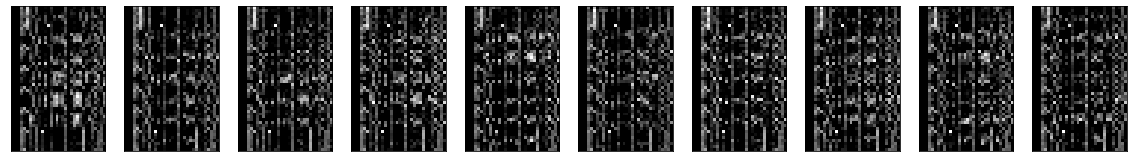

In [12]:
num_images = 10

random_test_image_ind = np.random.randint(x_test.shape[0], size=num_images)

plt.figure(figsize=(20, 8))
for i,image_index in enumerate(random_test_image_ind):
    ax = plt.subplot(1, num_images, i+1)
    plt.imshow(Denoise_encoded_imgs[image_index].reshape(7*7,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

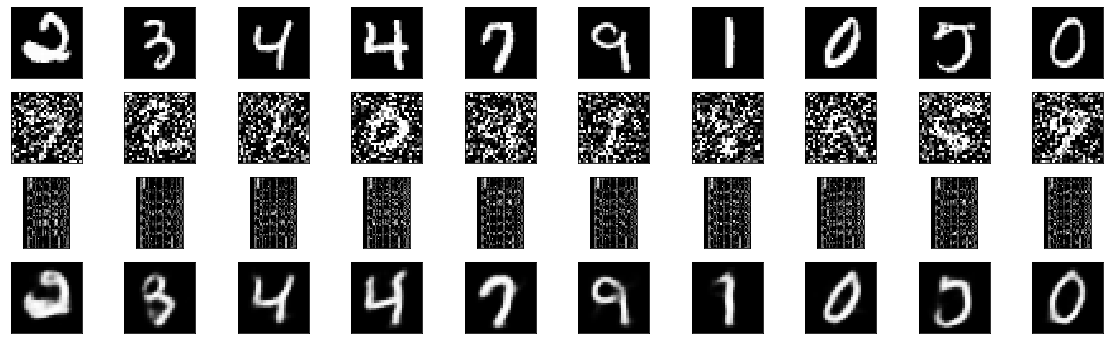

In [13]:
plt.figure(figsize=(20, 6))

for i,image_index in enumerate(random_test_image_ind):
    # display original
    ax = plt.subplot(4, num_images, i+1)
    plt.imshow(x_test[image_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # display noisy images
    ax = plt.subplot(4, num_images, i+num_images+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # compressed representation
    ax = plt.subplot(4, num_images, i+2*num_images+1)
    plt.imshow(Denoise_encoded_imgs[image_index].reshape(7*7,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, num_images, i+3*num_images+1)
    plt.imshow(Denoise_decoded_imgs[image_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()


In [14]:
#  free memory resources, it will interrupt the kernel
# os.kill(os.getpid(), signal.SIGTERM)